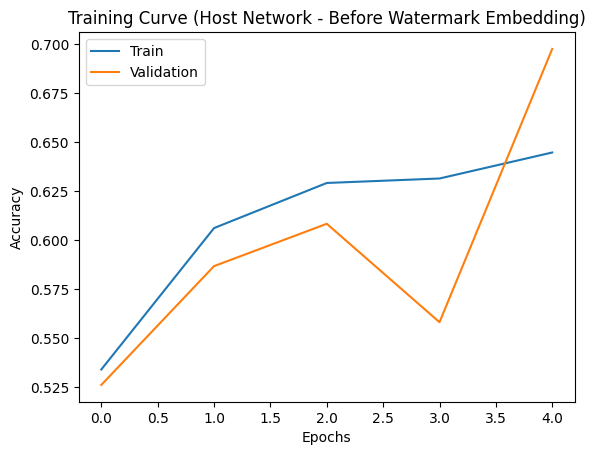

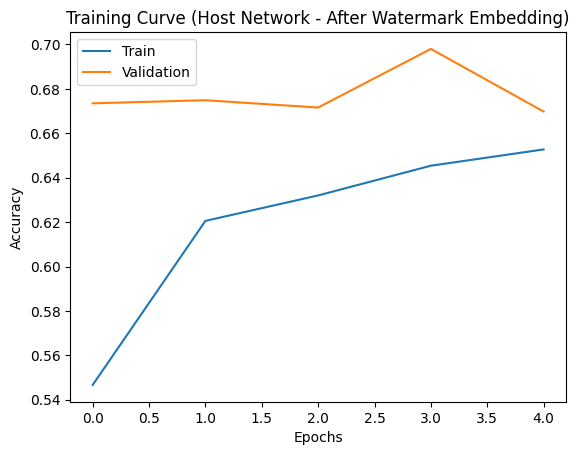

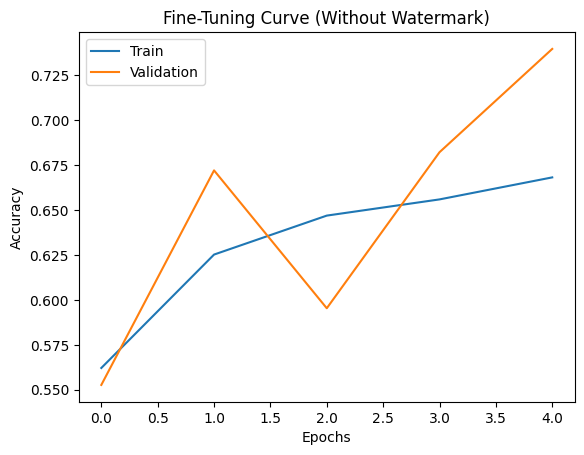

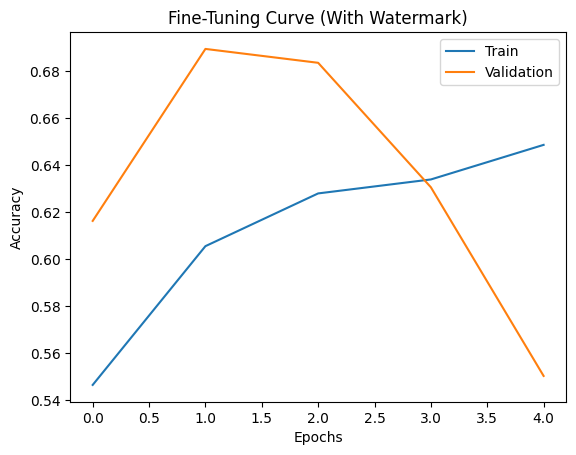

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import Regularizer

class WatermarkRegularizer(Regularizer):
    def __init__(self, watermark_strength, watermark):
        self.watermark_strength = watermark_strength
        self.watermark = watermark

    def __call__(self, x):
        return self.watermark_strength * tf.reduce_sum(tf.square(x - self.watermark))

# Define the watermark
watermark = np.random.normal(size=(100,))  # Adjust size according to your layer's dimensions

# Create a simple neural network model
def create_model():
    model = Sequential([
        Dense(100, input_shape=(784,), activation='relu',
              kernel_regularizer=WatermarkRegularizer(0.1, watermark)),  # Embed watermark in this layer
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Train the model without watermark for host network
host_model = create_model()
history_host = host_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=0)

# Extract the watermark
extracted_weights = host_model.layers[0].get_weights()[0]  # Assuming the watermark is embedded in the first layer's weights
extracted_watermark = extracted_weights.flatten()

# Train the model with watermark for host network
watermarked_model = create_model()
history_watermarked = watermarked_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=0)

# Simulate fine-tuning attack by training for additional epochs without watermark
host_model_fine_tuning = create_model()
history_fine_tuning_host = host_model_fine_tuning.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=0)

# Simulate fine-tuning attack by training for additional epochs with watermark
watermarked_model_fine_tuning = create_model()
history_fine_tuning_watermarked = watermarked_model_fine_tuning.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=0)

# Plotting the training curves
def plot_training_curves(history, title):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot training curves for host network (before and after watermark embedding)
plot_training_curves(history_host, 'Training Curve (Host Network - Before Watermark Embedding)')
plot_training_curves(history_watermarked, 'Training Curve (Host Network - After Watermark Embedding)')

# Plot training curves for fine-tuning (without and with watermark)
plot_training_curves(history_fine_tuning_host, 'Fine-Tuning Curve (Without Watermark)')
plot_training_curves(history_fine_tuning_watermarked, 'Fine-Tuning Curve (With Watermark)')


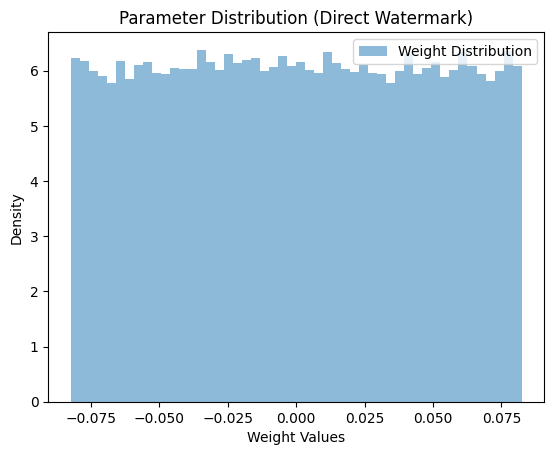

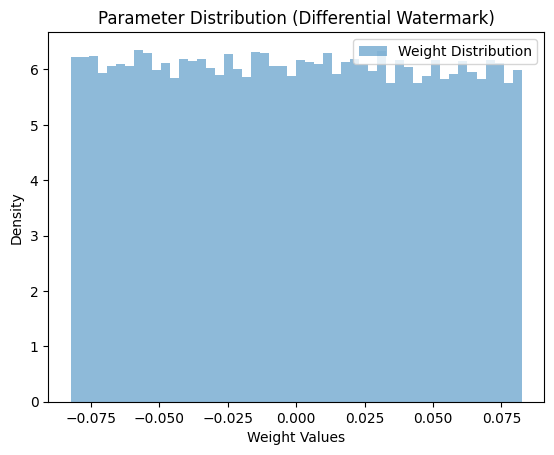

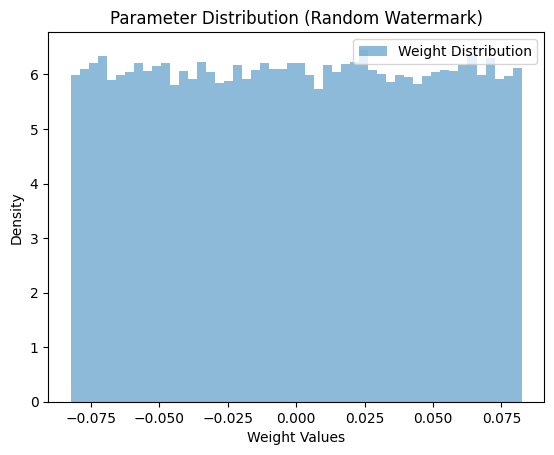

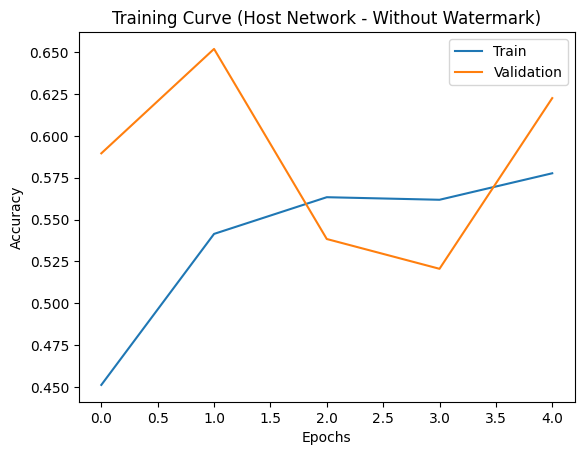

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import Regularizer

class WatermarkRegularizer(Regularizer):
    def __init__(self, watermark_strength, watermark, wtype='random'):
        self.watermark_strength = watermark_strength
        self.watermark = watermark
        self.wtype = wtype

    def set_watermark(self, p):
        if self.wtype == 'random':
            self.watermark = np.random.normal(size=p)
        elif self.wtype == 'direct':
            self.watermark = np.ones(p)
        elif self.wtype == 'diff':
            self.watermark = np.ones(p)
            self.watermark[1] = -1
        else:
            raise ValueError('Invalid watermark type. Use "random", "direct", or "diff".')

    def __call__(self, x):
        return self.watermark_strength * tf.reduce_sum(tf.square(x - self.watermark))

# Function to plot the distribution of parameters
def plot_parameter_distribution(weights, title):
    plt.hist(weights.flatten(), bins=50, density=True, alpha=0.5, label='Weight Distribution')
    plt.title(title)
    plt.xlabel('Weight Values')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))

# Define the watermark
watermark_size = 100
watermark = np.random.normal(size=(watermark_size,))  # Adjust size according to your layer's dimensions

# Create a simple neural network model
def create_model(watermark_type='random'):
    model = Sequential([
        Dense(100, input_shape=(28 * 28,), activation='relu',
              kernel_regularizer=WatermarkRegularizer(0.1, watermark, watermark_type)),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model without watermark for host network
host_model = create_model()
history_host = host_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=0)

# Extract the watermark
extracted_weights = host_model.layers[0].get_weights()[0]  # Assuming the watermark is embedded in the first layer's weights
extracted_watermark = extracted_weights.flatten()

# Plot the distribution of parameters for direct, differential, and random watermarks
direct_model = create_model(watermark_type='direct')
direct_model_weights = direct_model.layers[0].get_weights()[0]
plot_parameter_distribution(direct_model_weights, 'Parameter Distribution (Direct Watermark)')

diff_model = create_model(watermark_type='diff')
diff_model_weights = diff_model.layers[0].get_weights()[0]
plot_parameter_distribution(diff_model_weights, 'Parameter Distribution (Differential Watermark)')

random_model = create_model(watermark_type='random')
random_model_weights = random_model.layers[0].get_weights()[0]
plot_parameter_distribution(random_model_weights, 'Parameter Distribution (Random Watermark)')

# Plot training curves for host network (before and after watermark embedding)
plot_training_curves(history_host, 'Training Curve (Host Network - Without Watermark)')
